In [4]:
import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
TARGET_COLUMN = 'stress_level'
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS = 5
DATA_PATH = Path('Data.csv')
DROPED_COLUMNS = ['id', 'happiness_score', 'focus_score', 'high_risk_flag', 'productivity_score', 'digital_dependence_score', 'anxiety_score', 'depression_score']
N_JOBS = -1 # To utilize all available CPU cores for parallel processing

In [6]:
base_dir = Path.cwd()
output_dir = base_dir / "trained_models" / "classification"
output_dir.mkdir(parents=True, exist_ok=True)
report_path = base_dir / "performance_report_classification.csv"

## 1. Analysing Data


In [7]:
df = pd.read_csv(DATA_PATH)
df.head()

# In this model, we will predict the stress level of a person based on the following features:
# * Demographic: age, gender, region, education_level, daily_role
# * Digital Behavior: device_hours_per_day, phone_unlocks, notifications_per_day, social_media_mins, study_mins, physical_activity_days, sleep_hours, sleep_quality
# * Output feature: stress_level

df = df.drop(columns=DROPED_COLUMNS)
df.head(10)

,age,gender,region,income_level,education_level,daily_role,device_hours_per_day,phone_unlocks,notifications_per_day,social_media_mins,study_mins,physical_activity_days,sleep_hours,sleep_quality,stress_level,device_type
0,40,Female,Asia,High,High School,Part-time/Shift,3.54,45,561,98,34,7.0,9.123800,3.353627,6.593289,Android
1,27,Male,Africa,Lower-Mid,Master,Full-time Employee,5.65,100,393,174,102,2.0,8.837517,2.908147,4.126926,Laptop
2,31,Male,North America,Lower-Mid,Bachelor,Full-time Employee,8.87,181,231,595,140,1.0,6.486743,2.889213,1.429139,Android
3,41,Female,Middle East,Low,Master,Caregiver/Home,4.05,94,268,18,121,4.0,7.600504,3.097488,4.995512,Tablet
4,26,Female,Europe,Lower-Mid,Bachelor,Full-time Employee,13.07,199,91,147,60,1.0,5.197962,2.786098,9.448757,Android
5,37,Female,Middle East,Upper-Mid,Bachelor,Caregiver/Home,4.59,73,198,9,85,0.0,10.945226,2.797044,1.317061,Android
6,18,Female,Europe,Lower-Mid,High School,Unemployed_Looking,4.95,119,553,61,188,4.0,8.422325,3.065118,9.923969,iPhone
7,33,Female,Europe,Upper-Mid,Master,Full-time Employee,6.55,82,184,48,155,3.0,6.295213,2.952306,1.000000,Tablet
8,43,Female,South America,Lower-Mid,PhD,Full-time Employee,8.05,155,309,16,116,4.0,9.698407,3.065844,2.866001,Android
9,41,Female,Asia,Low,High School,Full-time Employee,2.33,38,110,249,155,5.0,9.722720,3.187426,1.976407,iPhone


In [17]:
df['device_type'].unique()

<StringArray>
['Android', 'Laptop', 'Tablet', 'iPhone']
Length: 4, dtype: str

* Working dataset with 15 inputs, 1 output,  3500 instances

In [22]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     3500 non-null   int64  
 1   gender                  3500 non-null   str    
 2   region                  3500 non-null   str    
 3   income_level            3500 non-null   str    
 4   education_level         3500 non-null   str    
 5   daily_role              3500 non-null   str    
 6   device_hours_per_day    3500 non-null   float64
 7   phone_unlocks           3500 non-null   int64  
 8   notifications_per_day   3500 non-null   int64  
 9   social_media_mins       3500 non-null   int64  
 10  study_mins              3500 non-null   int64  
 11  physical_activity_days  3500 non-null   float64
 12  sleep_hours             3500 non-null   float64
 13  sleep_quality           3500 non-null   float64
 14  stress_level            3500 non-null   float64
 15

In [23]:
df.isnull().sum()

age                       0
gender                    0
region                    0
income_level              0
education_level           0
daily_role                0
device_hours_per_day      0
phone_unlocks             0
notifications_per_day     0
social_media_mins         0
study_mins                0
physical_activity_days    0
sleep_hours               0
sleep_quality             0
stress_level              0
device_type               0
dtype: int64

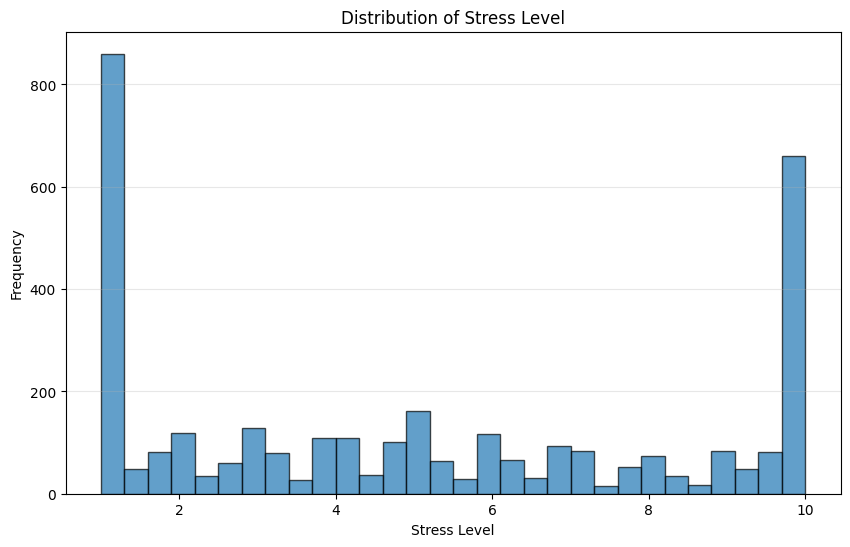

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(df['stress_level'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Stress Level')
plt.ylabel('Frequency')
plt.title('Distribution of Stress Level')
plt.grid(axis='y', alpha=0.3)
plt.show()

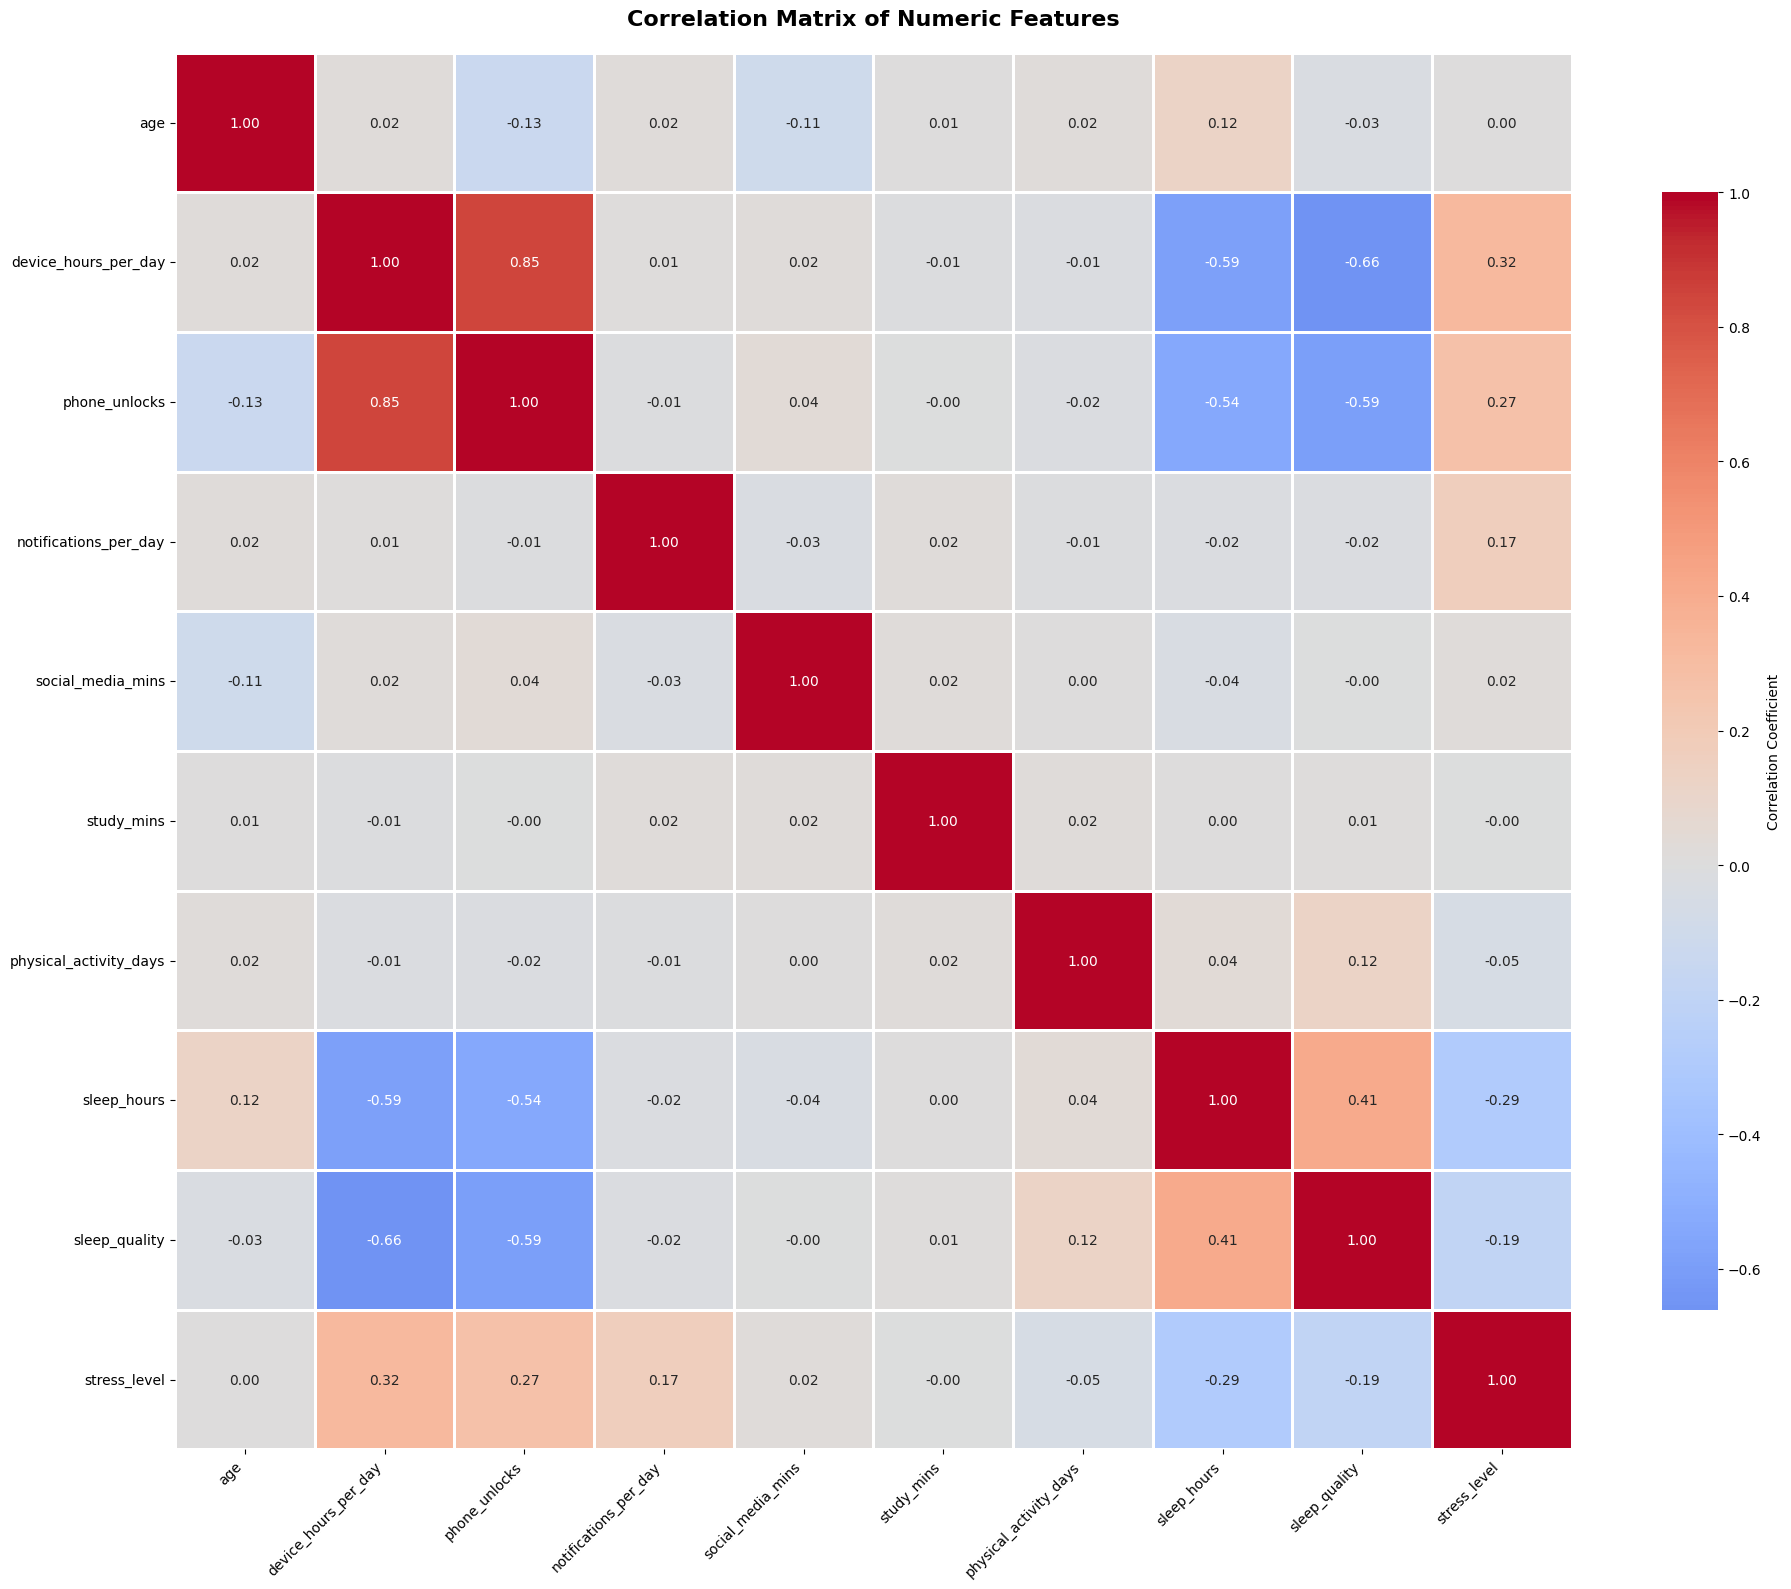

In [25]:
numerical_df = df.select_dtypes(include=['number'])
categorical_df = df.select_dtypes(include=['string'])

corr = numerical_df.corr()
plt.figure(figsize=(20, 16))
plt.title("Correlation Matrix of Numeric Features", fontsize=16, fontweight='bold', pad=20)
sns.heatmap(
    corr,
    annot=True,        
    fmt=".2f",            
    cmap="coolwarm",     
    center=0,             
    square=True,          
    linewidths=1,       
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


## 2. Features Scaling & Encoding

In [26]:
stress = df[TARGET_COLUMN]
labels, bins = pd.qcut(stress, q=3, labels=['Low', 'Moderate', 'High'], retbins=True)
X = df.drop(TARGET_COLUMN,axis=1)
y = labels
print('Class distribution (rounded up):\n', labels.value_counts().sort_index())


Class distribution (rounded up):
 stress_level
Low         1167
Moderate    1166
High        1167
Name: count, dtype: int64


In [27]:
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()
    numeric_trf = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categoric_trf = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_trf, numerical_features),
        ('cat', categoric_trf, categorical_features)
    ])
    return preprocessor

## 3. Evaluate model's performance

In [28]:
def evaluate_classification(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

## 4. Models

In [29]:
def model_selection():
    return {
        "logistic_regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        "ridge_classifier": RidgeClassifier(random_state=RANDOM_STATE),
        # "svm_rbf": SVC(kernel='rbf',probability=True, random_state=RANDOM_STATE),
        # "svm_linear": SVC(kernel='linear',probability=True, random_state=RANDOM_STATE),
        "random_forest": RandomForestClassifier(random_state=RANDOM_STATE,n_estimators=300, n_jobs=N_JOBS),
        "gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
        "extra_trees": ExtraTreesClassifier(random_state=RANDOM_STATE, n_estimators=300, n_jobs=N_JOBS),
        "adaboost": AdaBoostClassifier(random_state=RANDOM_STATE, n_estimators=200),
        "decision_tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "knn": KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS),
        "naive_bayes": GaussianNB(),
        # "mlp": MLPClassifier(hidden_layer_sizes=(128,64),random_state=RANDOM_STATE, max_iter=1000)
    } 

In [30]:
def model_param_grids():
    return {
        "logistic_regression": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__solver": ["lbfgs"],
            "model__class_weight": [None, "balanced"],
            "model__fit_intercept": [True, False],
        },
        "ridge_classifier": {
            "model__alpha": [0.1, 1.0, 10.0, 100.0],
            "model__class_weight": [None, "balanced"],
            "model__fit_intercept": [True, False],
        },
        # "svm_rbf": {
        #     "model__C": [0.1, 1, 10],
        #     "model__gamma": ["scale", "auto"],
        #     "model__class_weight": [None, "balanced"],
        # },
        # "svm_linear": {
        #     "model__C": [0.1, 1, 10, 100],
        #     "model__class_weight": [None, "balanced"],
        # },
        "random_forest": {
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
        },
        "gradient_boosting": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [2, 3, 4, 5],
        },
        "extra_trees": {
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
        },
        "adaboost": {
            "model__n_estimators": [50, 100, 200, 400],
            "model__learning_rate": [0.1, 0.5, 1.0],
        },
        "decision_tree": {
            "model__max_depth": [None, 5, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
        },
        "knn": {
            "model__n_neighbors": [3, 5, 7, 9, 11, 15],
            "model__weights": ["uniform", "distance"],
        },
        "naive_bayes": {
            "model__var_smoothing": [1e-9, 1e-8, 1e-7],
        },
        # "mlp": {
        #     "model__hidden_layer_sizes": [(64, 32), (128, 64), (256, 128)],
        #     "model__alpha": [0.0001, 0.001, 0.01],
        #     "model__learning_rate_init": [0.0005, 0.001, 0.01],
        # },
    }

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
preprocessor = build_preprocessor(X_train)
models = model_selection()
param_grids = model_param_grids()
results = []
scoring = {
    "accuracy": "accuracy",
    "precision_weighted": "precision_weighted",
    "recall_weighted": "recall_weighted",
    "f1_weighted": "f1_weighted",
}
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print(f"\nTraining model {name} with GridSearchCV")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', model)])
    if name not in param_grids:
        print(f"No hyperparameters defined for {name}, skipping GridSearchCV.")
    param_grid = param_grids.get(name, {})

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring, 
        refit="f1_weighted", 
        n_jobs=N_JOBS)
    
    grid_search.fit(X_train, y_train)
    best_pipeline = grid_search.best_estimator_
    best_idx = grid_search.best_index_
    cv_results = grid_search.cv_results_
    print(f"Best params for {name}: {grid_search.best_params_}")

    print(f"Evaluating best {name} model on test set...")
    preds = best_pipeline.predict(X_test)
    metrics = evaluate_classification(y_test, preds)
    print(f"Test set performance for {name}: {metrics}")

    model_path = output_dir / f"{name}.joblib"
    joblib.dump(best_pipeline, model_path)
    
    results.append({
        "model": name,
        "cv_accuracy": cv_results["mean_test_accuracy"][best_idx],
        "cv_precision_weighted": cv_results["mean_test_precision_weighted"][best_idx],
        "cv_recall_weighted": cv_results["mean_test_recall_weighted"][best_idx],
        "cv_f1_weighted": cv_results["mean_test_f1_weighted"][best_idx],
    })


Training model logistic_regression with GridSearchCV
Best params for logistic_regression: {'model__C': 1, 'model__class_weight': None, 'model__fit_intercept': True, 'model__solver': 'lbfgs'}
Evaluating best logistic_regression model on test set...
Test set performance for logistic_regression: {'accuracy': 0.46285714285714286, 'precision': 0.4547441620764414, 'recall': 0.46285714285714286, 'f1_score': 0.45323377697182665}

Training model ridge_classifier with GridSearchCV
Best params for ridge_classifier: {'model__alpha': 0.1, 'model__class_weight': 'balanced', 'model__fit_intercept': True}
Evaluating best ridge_classifier model on test set...
Test set performance for ridge_classifier: {'accuracy': 0.45571428571428574, 'precision': 0.4418213673119333, 'recall': 0.45571428571428574, 'f1_score': 0.43156632084727653}

Training model random_forest with GridSearchCV
Best params for random_forest: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}
Evaluating 

/home/tungo/Projects/digibuddy-model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tungo/Projects/digibuddy-model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tungo/Projects/digibuddy-model/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Best params for adaboost: {'model__learning_rate': 1.0, 'model__n_estimators': 400}
Evaluating best adaboost model on test set...
Test set performance for adaboost: {'accuracy': 0.4585714285714286, 'precision': 0.46109039611296143, 'recall': 0.4585714285714286, 'f1_score': 0.44905635626509416}

Training model decision_tree with GridSearchCV
Best params for decision_tree: {'model__max_depth': 5, 'model__min_samples_split': 2}
Evaluating best decision_tree model on test set...
Test set performance for decision_tree: {'accuracy': 0.4257142857142857, 'precision': 0.4743853684490556, 'recall': 0.4257142857142857, 'f1_score': 0.42545086254305325}

Training model knn with GridSearchCV
Best params for knn: {'model__n_neighbors': 15, 'model__weights': 'distance'}
Evaluating best knn model on test set...
Test set performance for knn: {'accuracy': 0.4057142857142857, 'precision': 0.4076782110048875, 'recall': 0.4057142857142857, 'f1_score': 0.4040622604051627}

Training model naive_bayes with Gri

In [32]:
results_df = pd.DataFrame(results).sort_values(by='cv_f1_weighted', ascending=False)
results_df.to_csv(report_path, index=False)
print("Model training and evaluation completed. Performance report saved to:", report_path)

Model training and evaluation completed. Performance report saved to: /home/tungo/Projects/digibuddy-model/performance_report_classification.csv
